<a href="https://colab.research.google.com/github/05shourya/05shourya/blob/main/BiLSTM_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Last time step
        return out

In [6]:
# Load your preprocessed dataset
df = pd.read_csv("RELIANCE_NS_20250327_194948_processed.csv")  # Should contain features like ['Close', 'MA', 'RSI']
features = df[['Close', 'MA5', 'MA20', 'MA50', 'RSI', 'Volatility', 'Returns']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

sequence_length = 100
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Still predicting 'Close' price

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)



In [7]:
# Model setup
input_size = X.shape[2]  # Number of features
model = BiLSTMModel(input_size=input_size, hidden_size=64, num_layers=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/100, Loss: 1.0137
Epoch 2/100, Loss: 0.9677
Epoch 3/100, Loss: 0.9225
Epoch 4/100, Loss: 0.8765
Epoch 5/100, Loss: 0.8281
Epoch 6/100, Loss: 0.7759
Epoch 7/100, Loss: 0.7183
Epoch 8/100, Loss: 0.6541
Epoch 9/100, Loss: 0.5827
Epoch 10/100, Loss: 0.5040
Epoch 11/100, Loss: 0.4190
Epoch 12/100, Loss: 0.3306
Epoch 13/100, Loss: 0.2435
Epoch 14/100, Loss: 0.1641
Epoch 15/100, Loss: 0.0997
Epoch 16/100, Loss: 0.0569
Epoch 17/100, Loss: 0.0404
Epoch 18/100, Loss: 0.0491
Epoch 19/100, Loss: 0.0737
Epoch 20/100, Loss: 0.0990
Epoch 21/100, Loss: 0.1143
Epoch 22/100, Loss: 0.1170
Epoch 23/100, Loss: 0.1092
Epoch 24/100, Loss: 0.0950
Epoch 25/100, Loss: 0.0784
Epoch 26/100, Loss: 0.0626
Epoch 27/100, Loss: 0.0495
Epoch 28/100, Loss: 0.0403
Epoch 29/100, Loss: 0.0349
Epoch 30/100, Loss: 0.0326
Epoch 31/100, Loss: 0.0328
Epoch 32/100, Loss: 0.0342
Epoch 33/100, Loss: 0.0362
Epoch 34/100, Loss: 0.0379
Epoch 35/100, Loss: 0.0389
Epoch 36/100, Loss: 0.0390
Epoch 37/100, Loss: 0.0382
Epoch 38/1

In [8]:
# Start with the last known 180-day sequence
pred_input = scaled_data[-180:].copy()
predictions = []

model.eval()
for _ in range(60):
    input_seq = torch.tensor(pred_input[-60:], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        pred = model(input_seq).item()
        predictions.append(pred)

        # Simulate next input (reuse last row, replace 'Close' with prediction)
        next_input = pred_input[-1].copy()
        next_input[0] = pred
        pred_input = np.vstack([pred_input, next_input])


In [9]:
# Create dummy array for inverse scaling
dummy = np.zeros((60, scaled_data.shape[1]))
dummy[:, 0] = predictions

predicted_prices = scaler.inverse_transform(dummy)[:, 0]
print("📈 Predicted Prices for Next 60 Days:")
print(predicted_prices)


📈 Predicted Prices for Next 60 Days:
[1294.8240311  1299.37764258 1302.81613714 1305.59711756 1307.83266562
 1309.62162582 1311.05124803 1312.19361241 1313.1071754  1313.83879877
 1314.4253922  1314.89632885 1315.27489466 1315.57954449 1315.82515814
 1316.02323367 1316.18314343 1316.31232732 1316.41677593 1316.50132036
 1316.56982551 1316.62538328 1316.67021599 1316.70673918 1316.73630558
 1316.76026788 1316.77968895 1316.79553499 1316.80828912 1316.8186277
 1316.82713045 1316.83408725 1316.8394981  1316.84413596 1316.84780761
 1316.85070627 1316.85321845 1316.85515089 1316.85679347 1316.85804956
 1316.85901578 1316.859982   1316.86065836 1316.86114147 1316.86162458
 1316.86210769 1316.86230094 1316.86249418 1316.86268743 1316.86288067
 1316.86307392 1316.86307392 1316.86326716 1316.86326716 1316.86336378
 1316.8634604  1316.8634604  1316.8634604  1316.8634604  1316.8634604 ]


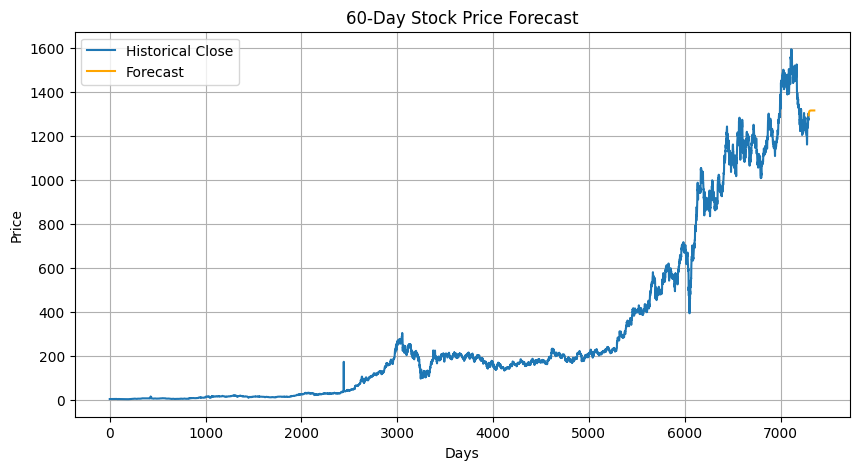

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(df)), df['Close'], label='Historical Close')
plt.plot(range(len(df), len(df)+60), predicted_prices, label='Forecast', color='orange')
plt.title("60-Day Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
